# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 14:26:22.879885: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 14:26:23.495917: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 14:26:23.495974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30945 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/ext_mnn_em_glove.6B.300d_amazon.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,path,product_type,label
0,cellphonecoverb07r8wd99zamazon brand - solimo ...,mobile coverb0773b95sramazon brand - solimo de...,61/6118fe0e.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07tg4stm2amazon brand - solimo de...,mobile coverb07tg4stm2amazon brand - solimo de...,e5/e5542967.jpg,CELLULAR_PHONE_CASE,1
2,dutch ovens oven cast iron pot combo bread for...,xiaomi redmi 6 pro mobile back case cover tran...,dc/dca2bc75.jpg,GROCERY,0
3,moto g5s plus mobile back case cover transpare...,moto g5s plus mobile back case cover transpare...,aa/aa17fc9d.jpg,CELLULAR_PHONE_CASE,1
4,throw-pillowsb074vlpc1zamazon brand stone & b...,throw-pillowsb074vlpc1zamazon brand stone & b...,7e/7e6df2bd.jpg,PILLOW,1
...,...,...,...,...,...
168148,mobile coverb07trwv2fzamazon brand - solimo de...,mobile coverb07trwv2fzamazon brand - solimo de...,63/63d1f4ff.jpg,CELLULAR_PHONE_CASE,1
168149,mobile coverb0857l9jb8amazon brand - solimo de...,mobile coverb0853wqlrzamazon brand - presto! d...,97/971c4f9b.jpg,CELLULAR_PHONE_CASE,0
168150,mobile coverb0856bdy4l365 everyday value trail...,mobile coverb07tf1f314concept 3 by skechers be...,1e/1e89c004.jpg,CELLULAR_PHONE_CASE,0
168151,urad dalb07t9tkptmamazon brand - solimo design...,"mobile coverb07tbv44sw365 everyday value, orga...",49/49cfd6eb.jpg,CELLULAR_PHONE_CASE,0


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

This part is largely based off of https://keras.io/examples/nlp/pretrained_word_embeddings/

GloVe Embeddings: https://nlp.stanford.edu/projects/glove/

In [11]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=None, output_sequence_length=300)

vectorizer.adapt(text)
vectorizer.adapt(text2)

In [12]:
text = vectorizer(text).numpy()
text.shape

(168153, 300)

In [13]:
text2 = vectorizer(text2).numpy()
text2.shape

(168153, 300)

In [14]:
voc = vectorizer.get_vocabulary()
voc[:10]

['',
 '[UNK]',
 'mobile',
 'back',
 'brand',
 'for',
 'solimo',
 'cover',
 'case',
 'designer']

In [15]:
word_index = dict(zip(voc, range(len(voc))))

In [16]:
embeddings_index = {}
with open("./glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [17]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10312 words (153638 misses)


GloVe Embedding only converts less than 10% of data!

# Image processing

## Load image model

In [18]:
from utils.img_processing import load_img_model, create_embeddings_from

In [19]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [20]:
%%time
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=4096)

Found 168153 validated image filenames.


2023-06-14 14:27:25.837612: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-06-14 14:27:27.144960: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


CPU times: user 4min 32s, sys: 2min 44s, total: 7min 16s
Wall time: 7min 10s


In [21]:
img.shape

(168153, 576)

# Save embeddings

In [22]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/glove/{img_model.name}")

In [23]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [74]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,cellphonecoverb07r8wd99zamazon brand - solimo ...,mobile coverb0773b95sramazon brand - solimo de...,61/6118fe0e.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07tg4stm2amazon brand - solimo de...,mobile coverb07tg4stm2amazon brand - solimo de...,e5/e5542967.jpg,CELLULAR_PHONE_CASE,1
2,dutch ovens oven cast iron pot combo bread for...,xiaomi redmi 6 pro mobile back case cover tran...,dc/dca2bc75.jpg,GROCERY,0
3,moto g5s plus mobile back case cover transpare...,moto g5s plus mobile back case cover transpare...,aa/aa17fc9d.jpg,CELLULAR_PHONE_CASE,1
4,throw-pillowsb074vlpc1zamazon brand stone & b...,throw-pillowsb074vlpc1zamazon brand stone & b...,7e/7e6df2bd.jpg,PILLOW,1
...,...,...,...,...,...
168148,mobile coverb07trwv2fzamazon brand - solimo de...,mobile coverb07trwv2fzamazon brand - solimo de...,63/63d1f4ff.jpg,CELLULAR_PHONE_CASE,1
168149,mobile coverb0857l9jb8amazon brand - solimo de...,mobile coverb0853wqlrzamazon brand - presto! d...,97/971c4f9b.jpg,CELLULAR_PHONE_CASE,0
168150,mobile coverb0856bdy4l365 everyday value trail...,mobile coverb07tf1f314concept 3 by skechers be...,1e/1e89c004.jpg,CELLULAR_PHONE_CASE,0
168151,urad dalb07t9tkptmamazon brand - solimo design...,"mobile coverb07tbv44sw365 everyday value, orga...",49/49cfd6eb.jpg,CELLULAR_PHONE_CASE,0


In [75]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168153, 576)

In [76]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168153, 300)

In [77]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(168153, 300)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [78]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [79]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [82]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Build Extended MNN-EM Model

![](../../assets/images/Extended_MNN_EM.png)

In [83]:
from utils.metrics import create_metrics

In [84]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [85]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": embedding_dim,
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [86]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity


class MNNEMGlove(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(self.head_config["txt_input_size"]), dtype=tf.int64, name="Text_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, text_features])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, text_features],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Image Input
        text_features = Input(shape=(self.txt_input_size), dtype=tf.int64, name="Text_Input_Head_Outer")

        embedding_layer = Embedding(
            num_tokens,
            self.txt_input_size,
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )

        x = embedding_layer(text_features)

        x = Flatten()(x)

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, text_features],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

class ExtendedMNNEMGloVe(object):
    def __init__(self, head_1_config, head_2_config,
                 combined_fc_layers, learning_rate,
                 metrics=["recall", "precision", "binary_accuracy",
                          "cosine_similarity"],
                 loss='binary_crossentropy') -> None:
        self.head_1_config = head_1_config
        self.head_2_config = head_2_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self._build_model()  # builds self.model variable

    def _build_model(self):
        head = _MNNEMHead(**self.head_1_config)

        tail = MNNEMGlove(
            head_config=self.head_2_config,
            combined_fc_layers=self.combined_fc_layers,
            learning_rate=self.learning_rate,
            metrics=self.metrics,
            name="MNN_EM_Tail")

        # Input Layer
        img_features = Input(
            shape=(self.head_1_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(self.head_1_config["txt_input_size"]), name="Text_Input")

        # Input Layer
        text_2_features = Input(
            shape=(self.head_2_config["txt_input_size"]), name="Text_2_Input")

        x = head.model([img_features, text_features])

        x = tail.model([x, text_2_features])

        model = Model(inputs=[img_features, text_features,
                      text_2_features], outputs=x, name="Extended_MNN_EM")

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)

        self.model = model

In [87]:
ext_mnn_em = ExtendedMNNEMGloVe(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [88]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         141945664   ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Text_Input_Head_Outer (InputLa  [(None, 300)]     0           []                  

In [89]:
# "Head"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [90]:
# Image CNN

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[2],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [91]:
# Text CNN (outer)

tf.keras.utils.plot_model(ext_mnn_em.model.layers[2].layers[3],
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [92]:
# "Tail"

tf.keras.utils.plot_model(ext_mnn_em.model.layers[4],
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [93]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          expand_nested=False,
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [94]:
from utils.metrics import create_callbacks

In [95]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [96]:
# Model is too big to save

config["model"]["training"]["callbacks"] = ['early_stopping', 'tensorboard']

In [97]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [98]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8512/8512 [==============================] - 113s 13ms/step - loss: 8.5410 - recall: 0.8838 - precision: 0.8982 - binary_accuracy: 0.8875 - cosine_similarity: 0.5202 - val_loss: 4.7907 - val_recall: 0.9823 - val_precision: 0.9754 - val_binary_accuracy: 0.9780 - val_cosine_similarity: 0.5177
Epoch 2/10
8512/8512 [==============================] - 113s 13ms/step - loss: 3.2390 - recall: 0.9768 - precision: 0.9815 - binary_accuracy: 0.9784 - cosine_similarity: 0.5202 - val_loss: 2.2249 - val_recall: 0.9872 - val_precision: 0.9810 - val_binary_accuracy: 0.9835 - val_cosine_similarity: 0.5176
Epoch 3/10
8512/8512 [==============================] - 111s 13ms/step - loss: 1.6523 - recall: 0.9879 - precision: 0.9896 - binary_accuracy: 0.9883 - cosine_similarity: 0.5202 - val_loss: 1.2684 - val_recall: 0.9913 - val_precision: 0.9859 - val_binary_accuracy: 0.9882 - val_cosine_similarity: 0.5175
Epoch 4/10
8512/8512 [==============================] - 111s 13ms/step - loss: 0.9885 - rec

# Evaluation

## Plot loss and metrics

In [99]:
from utils.metrics import plot_metrics

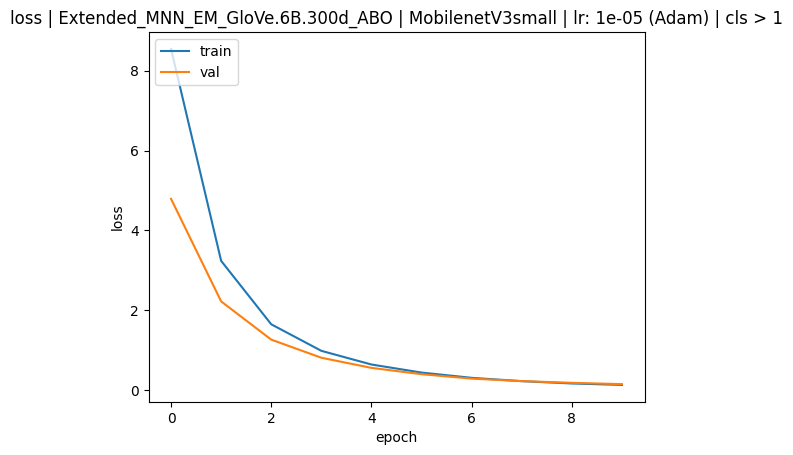

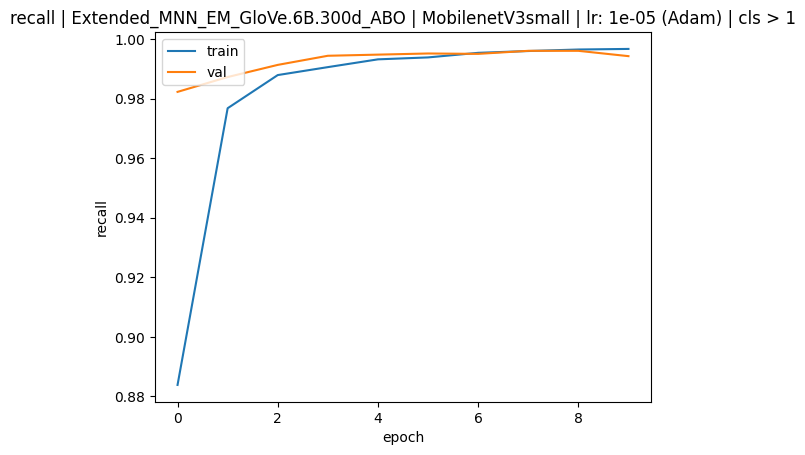

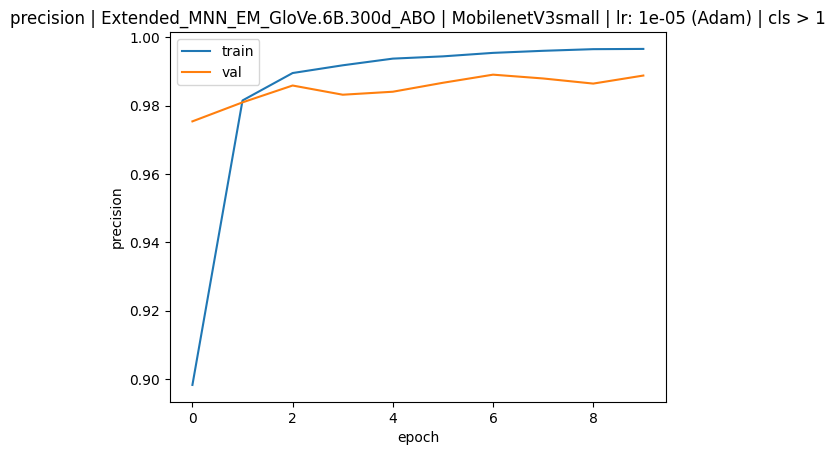

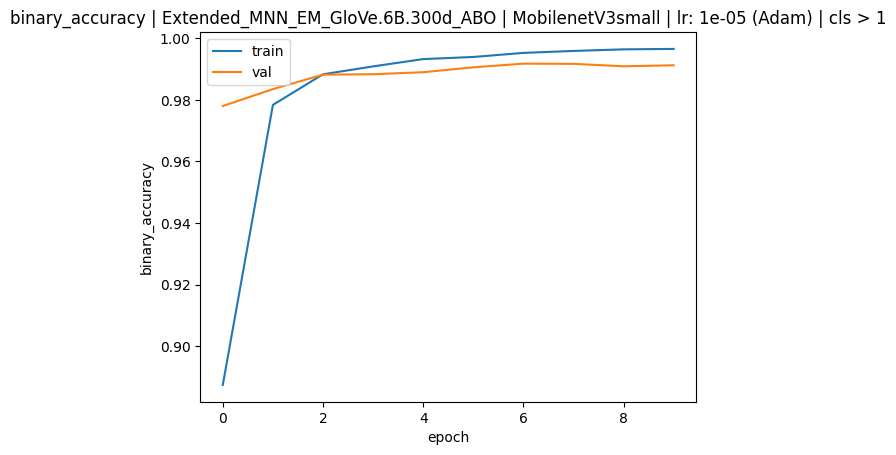

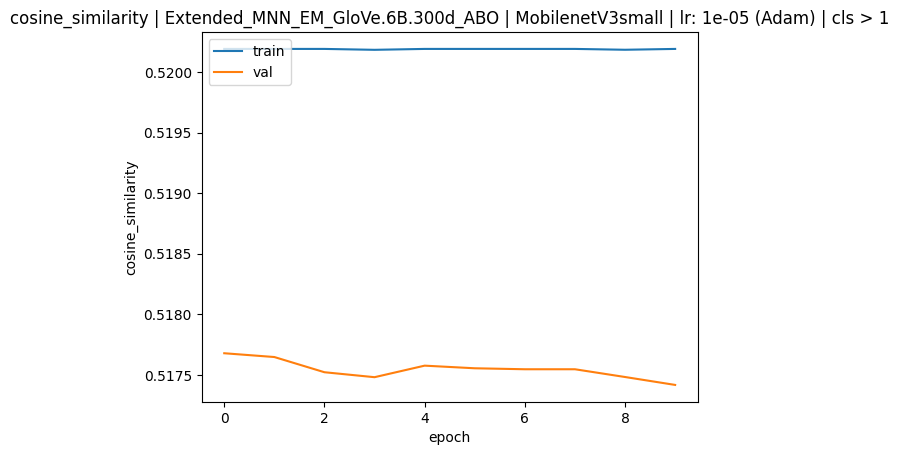

In [100]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [101]:
from utils.metrics import evaluate

In [102]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test,
         log_dir, model_name, img_model.name, optimizer_name, learning_rate,
         config["data"]["cls"])

16813/16813 [==============================] - 51s 3ms/step - loss: 0.1664 - recall: 0.9913 - precision: 0.9895 - binary_accuracy: 0.9901 - cosine_similarity: 0.5165
